In [0]:
!pip install tensorflow-gpu==2.0.0.a0

In [0]:
!pip install tensorflow-addons
!pip install tqdm
!pip install kaa-imlib2

In [0]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
from functools import partial
from skimage import color, transform
import matplotlib.pyplot as plt
import numpy as np
# import pylib as py
import os
# import tf2gan as gan
import tqdm
import glob
import sys
from torchvision import datasets

# from tensorflow.examples.tutorials.mnist import input_data
# import data
# import module
tf.__version__

'2.0.0-alpha0'

In [0]:
!mkdir mnist
!mkdir svhn


In [0]:
BUFFER_SIZE = 6000
BATCH_SIZE = 512

#Prepare SVHN

In [0]:
folder_mnist = "./mnist"
folder_svhn = "./svhn"
svhn_train = datasets.SVHN(root=folder_svhn, download=True, split="train")
svhn_test = datasets.SVHN(root=folder_svhn, download=True, split="test")

In [0]:
def transform_svhn(X):
    X = np.transpose(X, (0,2,3,1))
    X = np.array(X, np.float32)
    X /= 255
    X = X.reshape(len(X), 32, 32, 3)
    return X

In [0]:
print("Transforming SVHN train...")
X_svhn_train = transform_svhn(svhn_train.data)
X_svhn_validation = X_svhn_train[-10000:]
X_svhn_train = X_svhn_train[:-10000]
print("Transforming SVHN test...")
X_svhn_test = transform_svhn(svhn_test.data)

train_dataset_svhn = tf.data.Dataset.from_tensor_slices(X_svhn_train).shuffle(63257).repeat().batch(BATCH_SIZE)
validation_dataset_svhn = tf.data.Dataset.from_tensor_slices(X_svhn_train).shuffle(10000).repeat().batch(BATCH_SIZE)
test_dataset_svhn = tf.data.Dataset.from_tensor_slices(X_svhn_test).shuffle(26032).repeat().batch(200)

print(X_svhn_train.shape)
print(X_svhn_validation.shape)
print(X_svhn_test.shape)

Transforming SVHN train...
Transforming SVHN test...
(63257, 32, 32, 3)
(10000, 32, 32, 3)
(26032, 32, 32, 3)


In [0]:
!mkdir svhn_validation
!mkdir svhn_test

In [0]:
for i in range(len(X_svhn_validation)):
  plt.imsave('svhn_validation/{}.jpg'.format(i), np.array(X_svhn_validation[i]))

In [0]:
for i in range(len(X_svhn_test)):
  plt.imsave('svhn_test/{}.jpg'.format(i), np.array(X_svhn_test[i]))

#Prepare *MNIST*

In [0]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def transform_mnist(X):
#     X = X.reshape(len(X), 28, 28)
    X = np.array([transform.resize(im, [32,32]) for im in X])
    X /= 255
    X = X.reshape(len(X), 32, 32, 1)
    return X.astype('float32')

In [0]:
print("Transforming MNIST train...")
X_mnist_train = transform_mnist(train_images)
X_mnist_validation = X_mnist_train[-10000:]
X_mnist_train = X_mnist_train[:-10000]
X_mnist_test = transform_mnist(test_images)

train_dataset_mnist = tf.data.Dataset.from_tensor_slices(X_mnist_train).shuffle(50000).repeat().batch(BATCH_SIZE)
validation_dataset_mnist = tf.data.Dataset.from_tensor_slices(X_mnist_train).shuffle(10000).repeat().batch(BATCH_SIZE)
test_dataset_mnist = tf.data.Dataset.from_tensor_slices(X_mnist_test).shuffle(10000).repeat().batch(200)


Transforming MNIST train...


In [0]:
print(X_mnist_train.shape)
print(X_mnist_validation.shape)
print(X_mnist_test.shape)

(50000, 32, 32, 1)
(10000, 32, 32, 1)
(10000, 32, 32, 1)


In [0]:
!mkdir mnist_validation
!mkdir mnist_test

In [0]:
for i in range(len(X_mnist_validation)):
  plt.imsave('mnist_validation/{}.jpg'.format(i), np.array(X_mnist_validation[i]).reshape(32,32))

In [0]:
for i in range(len(X_mnist_test)):
  plt.imsave('mnist_test/{}.jpg'.format(i), np.array(X_mnist_test[i]).reshape(32,32))

In [0]:
itA = iter(train_dataset_mnist)
itB = iter(train_dataset_svhn)
itA_test = iter(test_dataset_mnist)
itB_test = iter(test_dataset_svhn)
itA_validation = iter(validation_dataset_mnist)
itB_validation = iter(validation_dataset_svhn)

In [0]:
def encoder_layer(inputs, filters=16, kernel_size=3, strides=2, activation='relu', instance_norm=True):
    
    x = inputs    
    if instance_norm:
      x = tfa.layers.InstanceNormalization()(x)     
    x = keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=True)(x)
    if activation == 'relu':
      x = keras.layers.ReLU()(x)
    else:
      x = keras.layers.LeakyReLU(alpha=0.2)(x)
    return x

def decoder_layer(inputs,paired_inputs,filters=16,kernel_size=3,strides=2,activation='relu',instance_norm=True):

  conv = keras.layers.Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')

  x = inputs
  if instance_norm:
    x = tfa.layers.InstanceNormalization()(x)
  x = conv(x)
  x = keras.layers.concatenate([x, paired_inputs])
  if activation == 'relu':
    x = keras.layers.ReLU()(x)
  else:
    x = keras.layers.LeakyReLU(alpha=0.2)(x)  
  return x  

def build_generator(input_shape,output_shape=None,kernel_size=3):

    inputs = keras.Input(shape=input_shape)
    channels = int(output_shape[-1])
    e1 = encoder_layer(inputs,32,kernel_size=kernel_size,activation='leaky_relu',strides=1)
    #32
    e2 = encoder_layer(e1,64,activation='leaky_relu',kernel_size=kernel_size)
    #16
    e3 = encoder_layer(e2,128,activation='leaky_relu',kernel_size=kernel_size)
    #8
    e4 = encoder_layer(e3,256,activation='leaky_relu',kernel_size=kernel_size)    
    #4
    d1 = decoder_layer(e4,e3,128,kernel_size=kernel_size)
    #8
    d2 = decoder_layer(d1,e2,64,kernel_size=kernel_size)
    #16
    d3 = decoder_layer(d2,e1,32,kernel_size=kernel_size)
    #32
    outputs = keras.layers.Conv2DTranspose(channels,kernel_size=kernel_size,strides=1,activation='sigmoid',padding='same')(d3)

    generator = keras.Model(inputs, outputs)

    return generator


def build_discriminator(input_shape,kernel_size=5):

    inputs = keras.Input(shape=input_shape)
    x = encoder_layer(inputs,32,kernel_size=kernel_size,activation='leaky_relu',instance_norm=False)
    x = encoder_layer(x,64,kernel_size=kernel_size,activation='leaky_relu',instance_norm=False)
    x = encoder_layer(x,128,kernel_size=kernel_size,activation='leaky_relu',instance_norm=False)
    x = encoder_layer(x,256,kernel_size=kernel_size,strides=1,activation='leaky_relu',instance_norm=False)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1)(x)
    outputs = keras.layers.Activation('sigmoid')(x)


    discriminator = keras.Model(inputs, outputs)

    return discriminator


In [0]:
import datetime
def train_cyclegan(models, epochs):
    # the models
    g_source, g_target, d_source, d_target, adv = models
    epochs = epochs
    # network parameters
    batch_size = 512
    train_steps =20000
    save_interval = 500
    valid = np.ones([batch_size, 1])
    fake = np.zeros([batch_size, 1])
    titles = ('MNIST predicted source images.','SVHN predicted target images.','MNIST reconstructed source images.','SVHN reconstructed target images.')

    valid_fake = np.concatenate((valid, fake))
    start_time = datetime.datetime.now()
    
    for ep in range(epochs):
      
      print(ep)
      #124 = len of svhn dataset / batch dimension
      for i in range(124):
        # train for an epoch
        real_source, real_target  = next(itA), next(itB)
        if ep==0 and i==0:
          test_generator((g_source, g_target), (real_source, real_target), 0, titles=titles, dirs=('./', './'), show=True)

        fake_target = g_target.predict(real_source)

        # combine real and fake into one batch
        x = np.concatenate((real_target, fake_target))
        # train the target discriminator using fake/real data
        metrics = d_target.train_on_batch(x, valid_fake)
        log = "%d: [d_target loss: %f]" % (i, metrics[0])

        # generate a batch of fake source data fr real target data
        fake_source = g_source.predict(real_target)
        x = np.concatenate((real_source, fake_source))
        # train the source discriminator using fake/real data
        metrics = d_source.train_on_batch(x, valid_fake)
        log = "%s [d_source loss: %f]" % (log, metrics[0])

        # train the adversarial network using forward and backward
        # cycles. the generated fake source and target data attempts
        # to trick the discriminators
        x = [real_source, real_target]
        y = [valid, valid, real_source, real_target]
        metrics = adv.train_on_batch(x, y)
        elapsed_time = datetime.datetime.now() - start_time
        fmt = "%s [adv loss: %f] [time: %s]"
        log = fmt % (log, metrics[0], elapsed_time)
#         if (i) % save_interval == 0:
      print(log)
      A = real_source
      B = real_target
    test_generator((g_source, g_target), (A, B), epochs, titles=titles, dirs=('./', './'), show=True)
    save_images((g_source, g_target))

    # save the models after training the generators
    g_source.save("mnist-g_source.h5")
    g_target.save("svhn-g_target.h5")

In [0]:
def build_cyclegan(source_name='source', target_name='target',kernel_size=5):

    source_shape = (32,32,1)
    target_shape = (32,32,3)
    lr = 2e-4
    decay = 6e-8
    gt_name = "gen_" + target_name
    gs_name = "gen_" + source_name
    dt_name = "dis_" + target_name
    ds_name = "dis_" + source_name

    # build target and source generators
    g_target = build_generator(input_shape=(32, 32, 1), output_shape=(32,32,3), kernel_size=kernel_size)
    g_source = build_generator(input_shape=(32, 32, 3), output_shape=(32,32,1), kernel_size=kernel_size)
    print('---- TARGET GENERATOR ----')
    g_target.summary()
    print('---- SOURCE GENERATOR ----')
    g_source.summary()

    # build target and source discriminators
    d_target = build_discriminator((32,32,3), kernel_size=kernel_size)
    d_source = build_discriminator((32,32,1), kernel_size=kernel_size)
    
    print('---- TARGET DISCRIMINATOR ----')
    d_target.summary()
    print('---- SOURCE DISCRIMINATOR ----')
    d_source.summary()

    optimizer = keras.optimizers.RMSprop(lr=lr, decay=decay)
    d_target.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    d_source.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

#     d_target.trainable = False
    for layer in d_target.layers:
        layer.trainable=False
    for layer in d_source.layers:
        layer.trainable=False        
#     d_source.trainable = False

    # build the computational graph for the adversarial model
    # forward cycle network and target discriminator
    source_input = keras.Input(shape=source_shape)
    fake_target = g_target(source_input)
    preal_target = d_target(fake_target)
    reco_source = g_source(fake_target)

    # backward cycle network and source discriminator
    target_input = keras.Input(shape=target_shape)
    fake_source = g_source(target_input)
    preal_source = d_source(fake_source)
    reco_target = g_target(fake_source)

    loss = ['mse', 'mse', 'mae', 'mae']
    loss_weights = [1., 1., 5., 5.]
    inputs = [source_input, target_input]
    outputs = [preal_source,
               preal_target,
               reco_source,
               reco_target]

    # build adversarial model
    adv = keras.Model(inputs, outputs, name='adversarial')
    optimizer = keras.optimizers.RMSprop(lr=lr*0.5, decay=decay*0.5)
    adv.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])
    print('---- ADVERSARIAL NETWORK ----')
    adv.summary()

    return g_source, g_target, d_source, d_target, adv

In [0]:
def save_images(generators):
    g_source = generators[0]
    g_target = generators[1]
    for j in range(20):
        real_source, real_target  = next(itA_validation), next(itB_validation)        
        pred_target_data = g_target.predict(real_source)
        pred_source_data = g_source.predict(real_target)
        for i in range(len(pred_target_data)):
          plt.imsave('mnist/{}.jpg'.format(j*512+i), np.array(pred_source_data[i]).reshape(32,32))
          plt.imsave('svhn/{}.jpg'.format(j*512+i), pred_target_data[i])
    

In [0]:
def test_generator(generators, test_data,step,titles,dirs,todisplay=100,show=False):
  
    # predict the output from test data
    g_source, g_target = generators
    test_source_data, test_target_data = test_data
    t1, t2, t3, t4 = titles
    title_pred_source = t1
    title_pred_target = t2
    title_reco_source = t3
    title_reco_target = t4
    dir_pred_source, dir_pred_target = dirs

    pred_target_data = g_target.predict(test_source_data)
    pred_source_data = g_source.predict(test_target_data)
    reco_source_data = g_source.predict(pred_target_data)
    reco_target_data = g_target.predict(pred_source_data)

    # display the 1st todisplay images
    imgs = pred_target_data[:todisplay]
    filename = 'svhn-{}.png'.format(step)
#     step = " Step: {:,}".format(step)
    title = title_pred_target 
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_target,
                   title=title,
                   show=show)
    
    filename = 'mnist-{}.png'.format(step)
    imgs = pred_source_data[:todisplay]
    title = title_pred_source
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_source,
                   title=title,
                   show=show)

    imgs = reco_source_data[:todisplay]
    title = title_reco_source
    filename = "reconstructed_source{}.png".format(step)
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_source,
                   title=title,
                   show=show)

    imgs = reco_target_data[:todisplay]
    title = title_reco_target
    filename = "reconstructed_target{}.png".format(step)
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_target,
                   title=title,
                    show=show)

In [0]:
import math
def display_images(imgs,filename,title='',imgs_dir=None,show=False):

    rows = imgs.shape[1]
    cols = imgs.shape[2]
    channels = imgs.shape[3]
    side = int(math.sqrt(imgs.shape[0]))
    assert int(side * side) == imgs.shape[0]

    # create saved_images folder
    if imgs_dir is None:
        imgs_dir = 'saved_images'
    save_dir = os.path.join(os.getcwd(), imgs_dir)
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filename = os.path.join(imgs_dir, filename)
    # rows, cols, channels = img_shape
    if channels==1:
        imgs = imgs.reshape((side, side, rows, cols))
    else:
        imgs = imgs.reshape((side, side, rows, cols, channels))
    imgs = np.vstack([np.hstack(i) for i in imgs])
    plt.figure()
    plt.axis('off')
#     plt.title(title)
    if channels==1:
        plt.imshow(imgs, interpolation='none', cmap='gray')
    else:
        plt.imshow(imgs, interpolation='none')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0, transparent=True)
    if show:
        plt.show()
    
    plt.close('all')

In [0]:
!git clone https://github.com/mseitzer/pytorch-fid.git

In [0]:
models = build_cyclegan("mnist", "svhn", kernel_size=5)

0


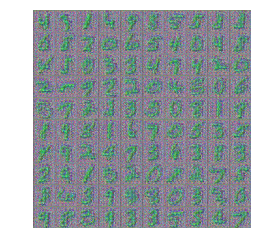

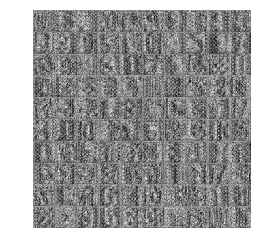

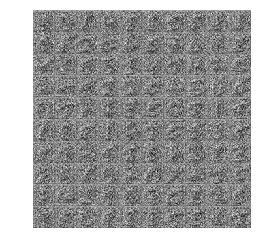

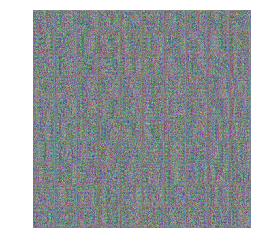

W0613 06:43:36.264725 140000947783552 training.py:2131] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0613 06:43:39.030397 140000947783552 training.py:2131] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


123: [d_target loss: 0.641619] [d_source loss: 0.628928] [adv loss: 1.402043] [time: 0:02:40.776964]


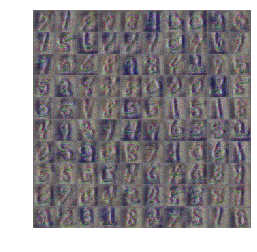

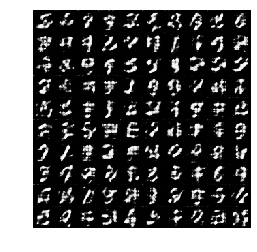

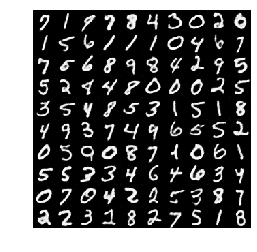

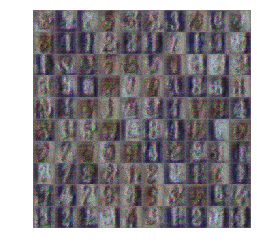

In [0]:
train_cyclegan(models, 1)

In [0]:
!python pytorch-fid/fid_score.py svhn svhn_validation.npz --gpu 0

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 95628359/95628359 [00:01<00:00, 78302338.05it/s]
100% 204/204 [00:43<00:00,  4.70it/s]
FID:  202.98822742672047


0


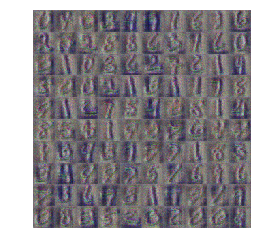

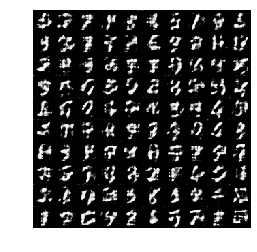

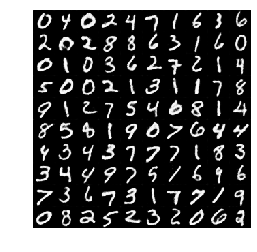

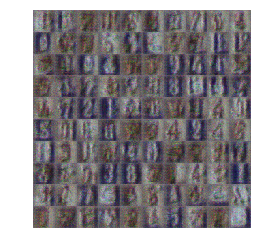

123: [d_target loss: 0.710166] [d_source loss: 0.640861] [adv loss: 1.539559] [time: 0:02:17.283116]
1
123: [d_target loss: 0.652215] [d_source loss: 0.618826] [adv loss: 1.607712] [time: 0:04:37.189282]
2
123: [d_target loss: 0.674092] [d_source loss: 0.630777] [adv loss: 1.495931] [time: 0:06:58.563687]
3
123: [d_target loss: 0.681297] [d_source loss: 0.768331] [adv loss: 1.255422] [time: 0:09:20.201558]
4
123: [d_target loss: 0.642790] [d_source loss: 0.638829] [adv loss: 1.307826] [time: 0:11:41.932437]
5
123: [d_target loss: 0.659597] [d_source loss: 0.626797] [adv loss: 1.378302] [time: 0:14:03.637486]
6
123: [d_target loss: 0.671833] [d_source loss: 0.606330] [adv loss: 1.480954] [time: 0:16:25.342186]
7
123: [d_target loss: 0.667112] [d_source loss: 0.636575] [adv loss: 1.416791] [time: 0:18:46.896873]
8
123: [d_target loss: 0.671063] [d_source loss: 0.599509] [adv loss: 1.483366] [time: 0:21:08.605304]
9
123: [d_target loss: 0.680643] [d_source loss: 0.622893] [adv loss: 1.348

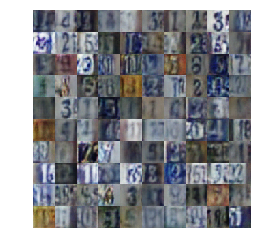

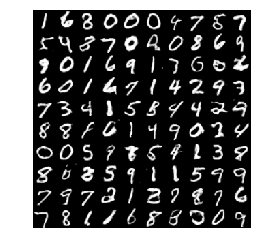

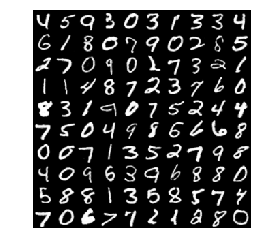

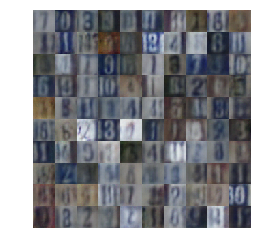

In [0]:
train_cyclegan(models, 50) #50

In [0]:
!python pytorch-fid/fid_score.py svhn svhn_validation.npz --gpu 0

100% 204/204 [00:38<00:00,  5.24it/s]
FID:  65.33613975282361


In [0]:
train_cyclegan(models, 50) #100

In [0]:
!python pytorch-fid/fid_score.py svhn svhn_validation.npz --gpu 0

100% 204/204 [00:38<00:00,  5.23it/s]
FID:  40.62574386774526


0


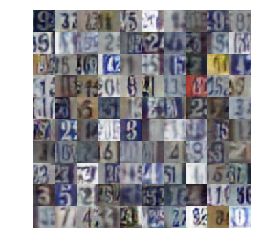

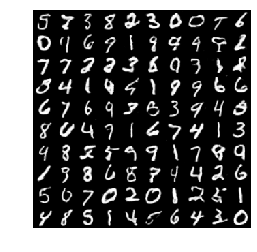

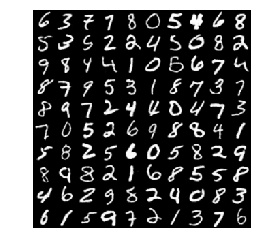

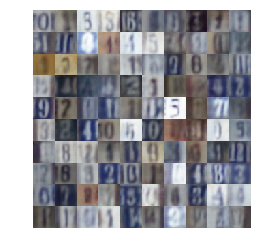

123: [d_target loss: 0.642629] [d_source loss: 0.375603] [adv loss: 1.397671] [time: 0:02:16.176616]
1
123: [d_target loss: 0.665441] [d_source loss: 0.555518] [adv loss: 1.149057] [time: 0:04:35.452850]
2
123: [d_target loss: 0.639700] [d_source loss: 0.376492] [adv loss: 1.684217] [time: 0:06:56.148477]
3
123: [d_target loss: 0.638288] [d_source loss: 0.325305] [adv loss: 1.362786] [time: 0:09:16.964305]
4
123: [d_target loss: 0.643057] [d_source loss: 0.320192] [adv loss: 1.583251] [time: 0:11:37.909786]
5
123: [d_target loss: 0.636168] [d_source loss: 0.353964] [adv loss: 1.444127] [time: 0:13:58.884345]
6
123: [d_target loss: 0.643515] [d_source loss: 0.400974] [adv loss: 1.138031] [time: 0:16:19.903888]
7
123: [d_target loss: 0.638815] [d_source loss: 0.512265] [adv loss: 1.653398] [time: 0:18:40.901821]
8
123: [d_target loss: 0.628824] [d_source loss: 0.291946] [adv loss: 1.585580] [time: 0:21:01.853048]
9
123: [d_target loss: 0.679691] [d_source loss: 0.293900] [adv loss: 1.376

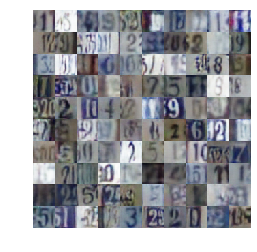

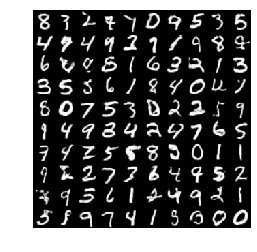

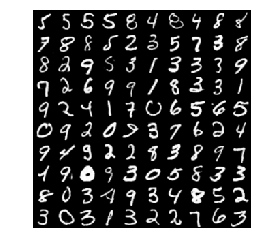

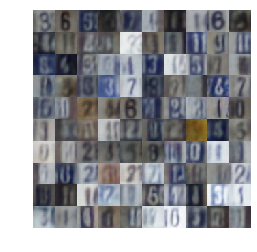

In [0]:
train_cyclegan(models, 50) #150

In [0]:
!python pytorch-fid/fid_score.py svhn svhn_validation.npz --gpu 0

100% 204/204 [00:42<00:00,  4.88it/s]
FID:  33.882110107892686


0


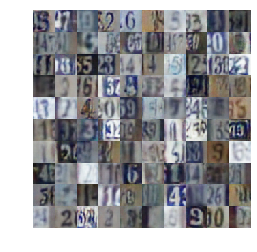

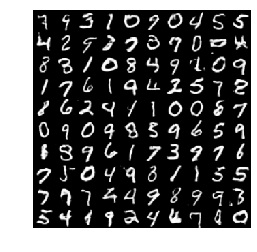

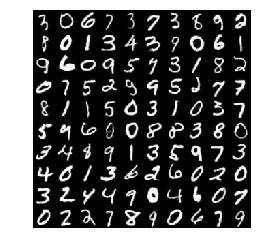

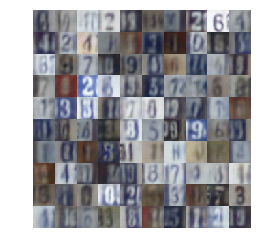

123: [d_target loss: 0.675749] [d_source loss: 0.276985] [adv loss: 1.638775] [time: 0:02:25.360067]
1
123: [d_target loss: 0.639763] [d_source loss: 0.355327] [adv loss: 1.233303] [time: 0:04:48.265357]
2
123: [d_target loss: 0.649243] [d_source loss: 0.449699] [adv loss: 1.457276] [time: 0:07:11.684583]
3
123: [d_target loss: 0.638502] [d_source loss: 0.247896] [adv loss: 1.468627] [time: 0:09:34.648443]
4
123: [d_target loss: 0.649654] [d_source loss: 0.259166] [adv loss: 1.488382] [time: 0:11:57.534780]
5
123: [d_target loss: 0.654084] [d_source loss: 0.188217] [adv loss: 1.607500] [time: 0:14:20.405015]
6
123: [d_target loss: 0.669839] [d_source loss: 0.410055] [adv loss: 1.452388] [time: 0:16:43.805167]
7
123: [d_target loss: 0.651451] [d_source loss: 0.284033] [adv loss: 1.637476] [time: 0:19:06.724778]
8
123: [d_target loss: 0.657307] [d_source loss: 0.345044] [adv loss: 1.584345] [time: 0:21:29.962775]
9
123: [d_target loss: 0.670352] [d_source loss: 0.283710] [adv loss: 1.479

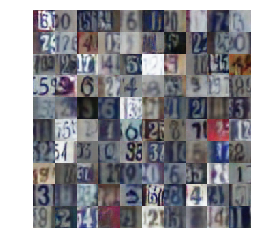

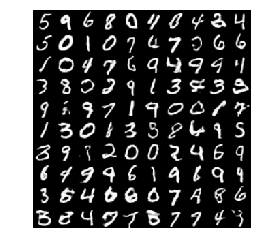

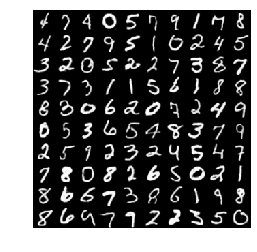

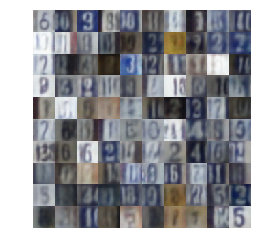

In [0]:
train_cyclegan(models, 50) #200

In [0]:
!python pytorch-fid/fid_score.py svhn svhn_validation.npz --gpu 0

100% 204/204 [00:42<00:00,  4.89it/s]
FID:  26.432762095598207


0


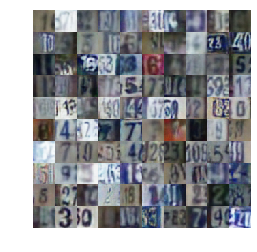

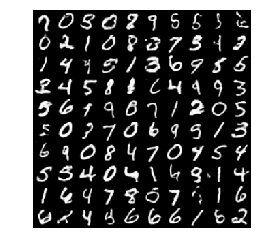

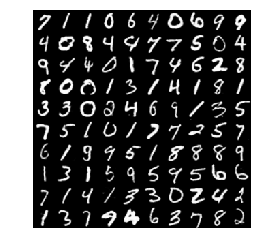

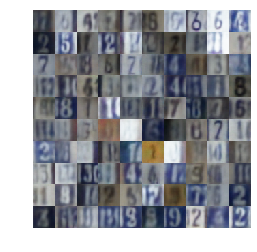

W0613 18:10:16.749739 140000947783552 training.py:2131] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0613 18:10:16.895711 140000947783552 training.py:2131] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


123: [d_target loss: 0.664977] [d_source loss: 0.386084] [adv loss: 0.897171] [time: 0:02:24.543315]
1
123: [d_target loss: 0.659522] [d_source loss: 0.231529] [adv loss: 1.501783] [time: 0:04:47.822732]
2
123: [d_target loss: 0.656852] [d_source loss: 0.209812] [adv loss: 1.449567] [time: 0:07:11.171316]
3
123: [d_target loss: 0.621908] [d_source loss: 0.131087] [adv loss: 1.534364] [time: 0:09:34.435504]
4
123: [d_target loss: 0.682256] [d_source loss: 0.183632] [adv loss: 1.746589] [time: 0:11:57.772191]
5
123: [d_target loss: 0.650874] [d_source loss: 0.130859] [adv loss: 1.557925] [time: 0:14:20.996692]
6
123: [d_target loss: 0.646545] [d_source loss: 1.206563] [adv loss: 1.541673] [time: 0:16:44.295538]
7
123: [d_target loss: 0.639814] [d_source loss: 0.132497] [adv loss: 1.693871] [time: 0:19:07.573037]
8
123: [d_target loss: 0.688420] [d_source loss: 0.876642] [adv loss: 0.858972] [time: 0:21:30.825284]
9
123: [d_target loss: 0.625838] [d_source loss: 0.252529] [adv loss: 1.539

In [0]:
train_cyclegan(models, 20) #250

In [0]:
!python pytorch-fid/fid_score.py svhn svhn_test.npz --gpu 0

 83% 170/204 [01:21<00:16,  2.10it/s]

In [0]:
rm svhn/*.mat

1: 202.98         50: 65.33       100: 40.62      150: 33.88            200: 26.43

1.   List item
2.   List item



In [0]:
g_source = keras.models.load_model('mnist-g_source.h5')
g_target = keras.models.load_model('svhn-g_target.h5')
d_target = keras.models.load_model('svhn-d_target.h5')
d_source = keras.models.load_model('mnist-d_source.h5')

In [0]:
!rm svhn/*.mat

In [0]:
# g_source, g_target, _, _, _ = build_cyclegan("mnist", "svhn", kernel_size=5)

save_images((g_source, g_target))

In [0]:
!7z a mnist.zip mnist/
!7z a svhn.zip svhn/

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!cp ./*.png gdrive/My\ Drive/

In [0]:
!cp ./*.zip gdrive/My\ Drive/

In [0]:
!cp ./*.h5 gdrive/My\ Drive/

In [0]:
!cp gdrive/My\ Drive/fid_stats_svhn_train.npz ./

In [0]:
import torch
print(torch.__version__) 

1.1.0
